# Actualization Criteria and Self-Consistent Mean-Field Projections

In this tutorial, we will build upon the concepts introduced in the previous tutorial, where we explored different actualization criteria for Adaptive Max-Ent. Notably, we discovered that the **Partial Sum criterion** provides the tightest control over errors, in contrast to the **Lieb-Robinson criterion**, which is lestightnt.  

However, as the complexity of the bases involved in the actualization g linearly with the number of actualizations and with the depth of the basis, $\ell$rows, managing this complexity becomes critical. To address this challenge, a Self-Consistent **Mean-Field (MF) projection** is applied, to reduce and organize the basis while retaining its essential features.  

In this tutorial, we will continue the discussion while maintaining the same initial conditions for the system.  

### Objectives:  

We will introduce two examples of **MF-aided Adaptive Max-Ent simulations**:  
1. The basis of observables is constructed as a **$m_0$-body projected Hierarchical Basis**, where the projection ensures that all elements of the basis remain manageable.  
2. We will demonstrate how Mean-Field projections enable efficient simulations while preserving the accuracy of the Adaptive Max-Ent scheme.  


In [1]:
import sys 
path= '../'
sys.path.insert(1, path) 

### long term ev 
import matplotlib.pyplot as plt
import numpy as np

# Configuration du style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,        # Taille de police
    'axes.labelsize': 14,   # Taille des labels des axes
    'axes.titlesize': 16,   # Taille des titres
    'legend.fontsize': 12,  # Taille des légendes
    'xtick.labelsize': 12,  # Taille des labels des ticks sur l'axe X
    'ytick.labelsize': 12,  # Taille des labels des ticks sur l'axe Y
    'font.family': 'serif', # Police de type "serif" pour un rendu professionnel
    'axes.linewidth': 1.5,  # Largeur des bordures des axes
    'grid.alpha': 0.5       # Transparence des grilles
})

import numpy as np
import scipy.linalg as linalg

from IPython.display import display_latex
from alpsqutip.geometry import graph_from_alps_xml, list_graph_in_alps_xml
from alpsqutip.alpsmodels import list_operators_in_alps_xml,model_from_alps_xml
from alpsqutip.utils import eval_expr
from alpsqutip.model import SystemDescriptor

import qutip as qutip
from typing import Callable, Optional, Tuple

models_lib_file = "../alpsqutip/lib/models.xml"
lattice_lib_file = "../alpsqutip/lib/lattices.xml"


In [16]:
from alpsqutip import restricted_maxent_toolkit as me ## custom library including basic linear algebra functions 
from alpsqutip.proj_evol import safe_exp_and_normalize ## function used to safely and robustly map K-states to states
from alpsqutip.operators.states.meanfield import one_body_from_qutip_operator, project_to_n_body_operator, self_consistent_quadratic_mfa
## functions used for Mean-Field projections

In [3]:
params={}

params['size']=7
params['Jx']=1.; params['Jy'] = .75*params['Jx']; params['Jz']=1.05*params['Jx']

from scipy.optimize import root, fsolve
Ffactor=np.real(max(np.roots(np.poly1d([1, 0, -(params['Jx']*params['Jy']+params['Jx']*params['Jy']+params['Jy']*params['Jz']), 
                           -2*params['Jx']*params['Jy']*params['Jz']]))))
chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
vLR=4*Ffactor*chi_y

In [4]:
system=SystemDescriptor(
    model=model_from_alps_xml(models_lib_file, "spin"),
    graph=graph_from_alps_xml(lattice_lib_file, "open chain lattice", parms={"L":params['size'], "a":1}),
    parms={"h":0,"J":params['Jx']}
)

sites=[s for s in system.sites]
sx_ops=[system.site_operator("Sx", '1[' + str(a) + ']') for a in range(len(system.sites))]
sy_ops=[system.site_operator("Sy", '1[' + str(a) + ']') for a in range(len(system.sites))]
sz_ops=[system.site_operator("Sz", '1[' + str(a) + ']') for a in range(len(system.sites))]

H = (params['Jx']*sum(sx_ops[i]*sx_ops[i+1] for i in range(params['size']-1)) + params['Jy']*sum(sy_ops[i]*sy_ops[i+1] for i in range(params['size']-1))
     +params['Jz']*sum(sz_ops[i]*sz_ops[i+1] for i in range(params['size']-1)))
idop=system.site_operator("identity", sites[0])

In [5]:
HBB0=[idop, system.site_operator('Sx', '1[0]'), system.site_operator('Sy', '1[0]'), system.site_operator('Sz', '1[0]')]

phi0 = np.array([.0, .25, .25, -100.])
K0 = me.Kstate_from_phi_basis(phi0, HBB0)
sigma0 = safe_exp_and_normalize(K0)[0]
phi0[0] = np.log(sigma0.tr())
K0 = me.Kstate_from_phi_basis(phi0, HBB0)
sigma0 = safe_exp_and_normalize(K0)[0]
[(sigma0 * op).tr() for op in sz_ops] 

[0.4999968750292966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [6]:
ptrace_list=[i for i in range(0,3)]
obs_SzA=.5*qutip.tensor(qutip.sigmaz(),qutip.qeye(2),qutip.qeye(2))+.5*qutip.tensor(qutip.qeye(2),qutip.sigmaz(),qutip.qeye(2))+.5*qutip.tensor(qutip.qeye(2),qutip.qeye(2),qutip.sigmaz())
obs_Sx3Sx4=(sx_ops[2]*sy_ops[3]).to_qutip()

timespan=np.linspace(.0, 650.1/vLR,75)

In [7]:
## exact dynamics
exact_K_at_timet=qutip.mesolve(H=H.to_qutip(), rho0=K0.to_qutip(), tlist=timespan)
exact_rho_at_timet=[safe_exp_and_normalize(K_at_timeti)[0] for K_at_timeti in exact_K_at_timet.states]
evs_obs_ex=[qutip.expect(rho_at_timeti.ptrace(ptrace_list), obs_SzA) for rho_at_timeti in exact_rho_at_timet]

In [8]:
# Here we store the results of the simulations
simulations = {}

### Mean-Field Projections for Basis Construction
To construct a new basis and compute the matrix elements of ${\cal G}$ and ${\cal H}$, it is necessary to approximate the instantaneous state ${\sigma}(t) \propto \exp(-{\bf K}(t))$. While exact computation of ${\bf K}(t)$ is often impractical, except in special cases such as when ${\bf K}(t)$ is a one-body operator, a suitable approximation suffices to compute the evolution.

Mean-Field Approach Overview
The Mean-Field (MF) approach is a widely used method in fields like condensed matter physics (e.g., superconductive models) and quantum information for simplifying complex systems. Its central idea is to approximate $n$-body interactions in a quantum system using effective one-body (or higher-order) averages.

This approach can be formalized through Mean-Field projections:

MF projections, denoted as $\pi^{\rm MF}_{B}: {\cal A} \rightarrow {\cal A}_B$, map the full algebra of observables, ${\cal A}$, to a subalgebra, ${\cal A}B$, relative to a suitable basis $B{\rm MF}$.
For product-state MF, the basis $B_{\rm MF} = B_{\rm prod}$ consists of local observables, such that $B_{\rm prod} = \bigsqcup_i B_i$, where $B_i$ spans a local subalgebra ${\cal A}_{B_i}$. The resulting Max-Ent states are product states: $\sigma^{\rm MF} = \bigotimes_i \sigma_i$.
Similarly, bosonic and fermionic MF states can be defined using quadratic forms (e.g., creation and annihilation operators) with the basis $B_{\rm MF} = B_{\rm quad}$.
Mean-Field Projection Formula
The MF projection of an observable ${\bf O}$ is given by:

$$\pi^{\rm MF}_{\tilde{B}, \sigma^{\rm MF}}({\bf O}) = \sum_{{\bf Q} \in \tilde{B}} \big({\bf Q} - \langle {\bf Q} \rangle_{\sigma^{\rm MF}}\big) 
    \frac{\partial \langle {\bf O} \rangle_{\sigma^{\rm MF}}}{\partial \langle {\bf Q} \rangle_{\sigma^{\rm MF}}} 
    + \langle {\bf O} \rangle_{\sigma^{\rm MF}}$$
    
This projection ensures consistency with the mean-field state, $\sigma^{\rm MF}$.

The mean-field state, $\sigma^{\rm MF}$, satisfies the self-consistent equation:

$$\sigma^{\rm MF} = \frac{\exp(- \pi^{\rm MF}_{\tilde{B}, \sigma^{\rm MF}}({\bf O}))}{{\rm Tr} \exp(- \pi^{\rm MF}_{\tilde{B}, \sigma^{\rm MF}}({\bf O}))}$$

The MF projection $\sigma^{\rm MF} = \exp(-\tilde{\bf K})$ of a state $\exp(-{\bf K})$ can be computed iteratively using:

$$\tilde{\bf K}^{(i+1)} = \pi^{\rm MF}_{\tilde{B}, \sigma_i^{\rm MF}}({\bf K})$$

Here, $\sigma_i^{\rm MF} = \exp(-\tilde{\bf K}^{(i)})$, and the initial guess $\sigma^{\rm MF (0)}$ can be the system's initial state $\sigma(0)$ or a prior MF state $\sigma^{\rm MF}(T_{n-1})$.

#### Benefits and Challenges
Advantages: The self-consistent MF approach often converges rapidly, providing manageable approximations of complex states.

Caveats: In ill-conditioned scenarios, convergence may fail or lead to non-trivial fixed points, requiring further refinements beyond this method's scope.

### Modified Hierarchical Basis  

The **Modified Hierarchical Basis** is constructed from the evolved state just before actualization. This state is then projected onto $m_0$-body observables, ensuring that the basis remains efficient and adapted to the system's current dynamics.

### First set of parameters

Here, we choose $(m_0, \ell, \epsilon) = (3, 3, 1\times10^{-4})$.

In [9]:
simulations[1] = {
    "parms":{
    "chosen_depth": 3,
    "m0": 3,
    "eps": 1e-4,
    },
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

In [10]:
current_simulation = simulations[1]
current_simulation_parms = current_simulation["parms"]
chosen_depth = current_simulation_parms["chosen_depth"]
eps_tol = current_simulation_parms["eps"]
m0 = current_simulation_parms["m0"]


# Initialize variables to track errors, saved cut times, expectation values, and commutators

saved_cut_times_index_ell = current_simulation["saved_cut_times_index_ell"]  
no_acts_ell = current_simulation["no_acts_ell"]
current_simulation["number_of_commutators_ell"] = number_of_commutators_ell = [chosen_depth]


# to be used in storing the values of the partial sum at each time
local_bound_error_ell = current_simulation["local_bound_error_ell"]
# to be used in storing the spectral norm of the Hij tensor at each actualization of the (orthonormalized) basis
spectral_norm_Hij_tensor_ell=current_simulation["spectral_norm_Hij_tensor_ell"]
# Norm of the orthogonal component of the commutators
instantaneous_w_errors =  current_simulation["instantaneous_w_errors"]


# Start the computation

ev_obs_maxent_act_partialSum_ell = [qutip.expect(sigma0.to_qutip().ptrace(ptrace_list), obs_SzA)]
current_simulation["ev_obs_maxent_act_partialSum_ell"] = ev_obs_maxent_act_partialSum_ell


# Compute the scalar product operator used for orthogonalization
sp_local = me.fetch_covar_scalar_product(sigma=sigma0.to_qutip()); local_t_value = .0  

# Build the initial Krylov basis and orthogonalize it
HBB_ell_act = me.build_Hierarch(generator=H, seed_op=K0.to_qutip(), deep=chosen_depth)  
orth_basis_act = me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)  

# Compute the Hamiltonian tensor for the basis
Hij_tensor_act, w_errors = me.fn_Hij_tensor_with_errors(generator=H.to_qutip(), basis=orth_basis_act, sp=sp_local)
instantaneous_w_errors.append(w_errors)

spectral_norm_Hij_tensor_ell.append(linalg.norm(Hij_tensor_act))

# Initial condition
phi0_proj_act = me.project_op(K0.to_qutip(), orth_basis_act, sp_local)  

# Initialize lists to store time-evolved values
phi_at_timet = [phi0_proj_act]  
K_at_timet = [K0.to_qutip()]  
sigma_at_timet = [me.safe_expm_and_normalize(K_at_timet[0])]  

# Iterate through the time steps
for t in timespan[1:]:
    # Evolve the state phi(t) for a small time window
    phi_local = np.real(linalg.expm(Hij_tensor_act * (t - local_t_value)) @ phi0_proj_act)  
    
    # Compute the new K-state from the orthogonal basis and phi(t)
    K_local = me.Kstate_from_phi_basis(phi=-phi_local, basis=orth_basis_act)  
    
    # Normalize to obtain the updated density matrix sigma(t)
    sigma_local = safe_exp_and_normalize(K_local)[0]  
    
    # Record expectation values of the observable
    ev_obs_maxent_act_partialSum_ell.append(qutip.expect(sigma_local.ptrace(ptrace_list), obs_SzA))  
    
    # Calculate the local error bound using partial sums
    local_bound_error_ell.append(me.m_th_partial_sum(phi=phi_local, m=2) / me.m_th_partial_sum(phi=phi_local, m=0))  
    
    # Check if the local error exceeds the threshold
    if abs(local_bound_error_ell[-1]) >= eps_tol:
        # If positive, perform actualization
        no_acts_ell.append(no_acts_ell[-1] + 1)    

        # Log errors at specific intervals for debugging
        if list(timespan).index(t) % 50 == 0:  
            print("error", t)  
        
        # Update the local time value and save the cut time index
        local_t_value = t  
        saved_cut_times_index_ell.append(list(timespan).index(t))  

        # Map the K-local state onto a Mean-Field state, retaining only its one-body correlations, to be used in sp
        K_act, sigma_act=me.mft_state_it(K_local, sigma_local, max_it=10)
        sigma_act=sigma_act.to_qutip()
        
        # Recompute the scalar product using the MF state
        sp_local = me.fetch_covar_scalar_product(sigma=sigma_act)  

        # The new basis is spanned from the K_local state
        HBB_ell_act = me.build_Hierarch(generator=H, seed_op=K_local, deep=chosen_depth)  

        # The growth in complexity of the basis is arrested by projecting this basis onto simpler basis
        # composed of $nmax$-body observables only, with $nmax$ much smaller than the size of the system. 
        HBB_ell_act=[project_to_n_body_operator(one_body_from_qutip_operator(op), nmax=m0).to_qutip() for op in HBB_ell_act]
          
        orth_basis_act = me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)  
        
        # Recompute the Hamiltonian tensor and project the state
        Hij_tensor_act, w_errors = me.fn_Hij_tensor_with_errors(generator=H.to_qutip(), basis=orth_basis_act, sp=sp_local)  
        instantaneous_w_errors.append(w_errors)
        spectral_norm_Hij_tensor_ell.append(linalg.norm(Hij_tensor_act))
        phi0_proj_act = me.project_op(K_local, orth_basis_act, sp_local)  
    else:
        # If error is below the threshold, retain the current basis and sp
        number_of_commutators_ell.append(number_of_commutators_ell[-1])  
        no_acts_ell.append(no_acts_ell[-1])  


error 40.864628580943155


### Second set of parameters

Here, we choose $(m_0, \ell, \epsilon) = (1, 5, 2\times10^{-2})$

In [32]:
simulations[2] = {
    "parms":{
    "chosen_depth": 5,
    "m0": 3,
    "eps": 1e-2,
    },
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

In [33]:
current_simulation = simulations[2]
current_simulation_parms = current_simulation["parms"]
chosen_depth = current_simulation_parms["chosen_depth"]
eps_tol = current_simulation_parms["eps"]
m0 = current_simulation_parms["m0"]


# Initialize variables to track errors, saved cut times, expectation values, and commutators

saved_cut_times_index_ell = current_simulation["saved_cut_times_index_ell"]  
no_acts_ell = current_simulation["no_acts_ell"]
current_simulation["number_of_commutators_ell"] = number_of_commutators_ell = [chosen_depth]


# to be used in storing the values of the partial sum at each time
local_bound_error_ell = current_simulation["local_bound_error_ell"]
# to be used in storing the spectral norm of the Hij tensor at each actualization of the (orthonormalized) basis
spectral_norm_Hij_tensor_ell=current_simulation["spectral_norm_Hij_tensor_ell"]
# Norm of the orthogonal component of the commutators
instantaneous_w_errors =  current_simulation["instantaneous_w_errors"]


# Start the computation

ev_obs_maxent_act_partialSum_ell = [qutip.expect(sigma0.to_qutip().ptrace(ptrace_list), obs_SzA)]
current_simulation["ev_obs_maxent_act_partialSum_ell"] = ev_obs_maxent_act_partialSum_ell


# Compute the scalar product operator used for orthogonalization
sp_local = me.fetch_covar_scalar_product(sigma=sigma0.to_qutip()); local_t_value = .0  

# Build the initial Krylov basis and orthogonalize it
HBB_ell_act = me.build_Hierarch(generator=H, seed_op=K0.to_qutip(), deep=chosen_depth)  
orth_basis_act = me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)  

# Compute the Hamiltonian tensor for the basis
Hij_tensor_act, w_errors = me.fn_Hij_tensor_with_errors(generator=H.to_qutip(), basis=orth_basis_act, sp=sp_local)
instantaneous_w_errors.append(w_errors)

spectral_norm_Hij_tensor_ell.append(linalg.norm(Hij_tensor_act))

# Initial condition
phi0_proj_act = me.project_op(K0.to_qutip(), orth_basis_act, sp_local)  

# Initialize lists to store time-evolved values
phi_at_timet = [phi0_proj_act]  
K_at_timet = [K0.to_qutip()]  
sigma_at_timet = [me.safe_expm_and_normalize(K_at_timet[0])]  

# Iterate through the time steps
for t in timespan[1:]:
    # Evolve the state phi(t) for a small time window
    phi_local = np.real(linalg.expm(Hij_tensor_act * (t - local_t_value)) @ phi0_proj_act)  
    
    # Compute the new K-state from the orthogonal basis and phi(t)
    K_local = me.Kstate_from_phi_basis(phi=-phi_local, basis=orth_basis_act)  
    
    # Normalize to obtain the updated density matrix sigma(t)
    sigma_local = safe_exp_and_normalize(K_local)[0]  
    
    # Record expectation values of the observable
    ev_obs_maxent_act_partialSum_ell.append(qutip.expect(sigma_local.ptrace(ptrace_list), obs_SzA))  
    
    # Calculate the local error bound using partial sums
    local_bound_error_ell.append(me.m_th_partial_sum(phi=phi_local, m=2) / me.m_th_partial_sum(phi=phi_local, m=0))  
    
    # Check if the local error exceeds the threshold
    if abs(local_bound_error_ell[-1]) >= eps_tol:
        # If positive, perform actualization
        no_acts_ell.append(no_acts_ell[-1] + 1)    

        # Log errors at specific intervals for debugging
        if list(timespan).index(t) % 50 == 0:  
            print("error", t)  
        
        # Update the local time value and save the cut time index
        local_t_value = t  
        saved_cut_times_index_ell.append(list(timespan).index(t))  

        # Map the K-local state onto a Mean-Field state, retaining only its one-body correlations, to be used in sp
        K_act, sigma_act=me.mft_state_it(K_local, sigma_local, max_it=10)
        sigma_act=sigma_act.to_qutip()
        
        # Recompute the scalar product using the MF state
        sp_local = me.fetch_covar_scalar_product(sigma=sigma_act)  

        # The new basis is spanned from the K_local state
        HBB_ell_act = me.build_Hierarch(generator=H, seed_op=K_local, deep=chosen_depth)  

        # The growth in complexity of the basis is arrested by projecting this basis onto simpler basis
        # composed of $nmax$-body observables only, with $nmax$ much smaller than the size of the system. 
        HBB_ell_act=[project_to_n_body_operator(one_body_from_qutip_operator(op), nmax=m0).to_qutip() for op in HBB_ell_act]
          
        orth_basis_act = me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)  
        
        # Recompute the Hamiltonian tensor and project the state
        Hij_tensor_act, w_errors = me.fn_Hij_tensor_with_errors(generator=H.to_qutip(), basis=orth_basis_act, sp=sp_local)  
        instantaneous_w_errors.append(w_errors)
        spectral_norm_Hij_tensor_ell.append(linalg.norm(Hij_tensor_act))
        phi0_proj_act = me.project_op(K_local, orth_basis_act, sp_local)  
    else:
        # If error is below the threshold, retain the current basis and sp
        number_of_commutators_ell.append(number_of_commutators_ell[-1])  
        no_acts_ell.append(no_acts_ell[-1])  


error 40.864628580943155


#### Velocities 

In [34]:
for key, simulation in simulations.items():
    simulation["velocity_mu_ell"] = np.array(simulation["spectral_norm_Hij_tensor_ell"])
    times_act_ell  = np.array(simulation["saved_cut_times_index_ell"])
    simulation["times_act_ell"] = times_act_ell
    simulation["velocity_PS_ell"] = np.array([1/(times_act_ell[i+1]-times_act_ell[i]) for i in range(len(times_act_ell)-1)])

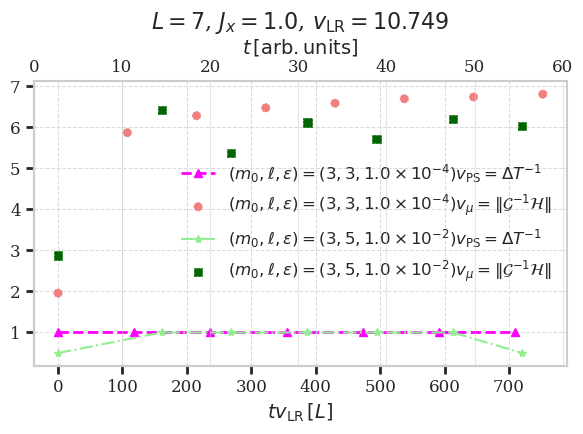

In [35]:
# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(6, 4.5))

n=10; m=11


def latex_scientific_notation(value):
    exponent = int(np.log10(value))
    if exponent:
        value = value / 10**exponent
        return f"{value}" + r" \times 10^{" + str(exponent) +"}"
    return f"{value}"

sim_parms = simulations[1]["parms"]
sim1_parms_str = f"{sim_parms['m0']}, {sim_parms['chosen_depth']}, {latex_scientific_notation(sim_parms['eps'])}"
sim_parms = simulations[2]["parms"]
sim2_parms_str = f"{sim_parms['m0']}, {sim_parms['chosen_depth']}, {latex_scientific_notation(sim_parms['eps'])}"

# Adjusted plot with different shades and symbols for clarity
ax.plot(simulations[1]["times_act_ell"][:-1][::m] * vLR,  simulations[1]["velocity_PS_ell"][::m], 
        label=r'$(m_0, \ell, \epsilon) = (' + sim1_parms_str  +r') v_{\rm PS}=\Delta T^{-1}$', 
        color="magenta", linestyle='--', marker='^', linewidth=2)
ax.scatter(simulations[1]["times_act_ell"][:-1][::n] * vLR, simulations[1]["velocity_mu_ell"][::n], 
           label=r'$(m_0, \ell, \epsilon) = (' + sim1_parms_str  +r') v_{\mu}=\|{\cal G}^{-1}{\cal H}\|$', 
           color='lightcoral', linestyle='--', marker='o', linewidth=0.5)

ax.plot(simulations[2]["times_act_ell"][:-1][::n] * vLR, simulations[2]["velocity_PS_ell"][::n], 
        label=r'$(m_0, \ell, \epsilon) = (' + sim2_parms_str  + r') v_{\rm PS}=\Delta T^{-1}$', 
        color="lightgreen", linestyle='dashdot', marker='*')
ax.scatter(simulations[2]["times_act_ell"][:-1][::n] * vLR, simulations[2]["velocity_mu_ell"][::n], 
           label=r'$(m_0, \ell, \epsilon) = (' + sim2_parms_str   + r') v_{\mu}=\|{\cal G}^{-1}{\cal H}\|$', 
           color='darkgreen', linestyle='--', marker='s', linewidth=0.5)

# Bordures uniquement à gauche et en bas (style minimaliste)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Personnalisation des ticks
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)

ax.legend(frameon=False, loc='center right')

# Create a secondary x-axis (twinned) and set its limits
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[-1])

# Set axis labels
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Format the title using the `params` dictionary values
# Ensure proper LaTeX formatting and consistent escape sequences
plt.title(r'$L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

# Adjustment final et affichage
plt.tight_layout()

#plt.savefig('Velocity Comparison', format='pdf')
#plt.show()

#### Expectation values of observables

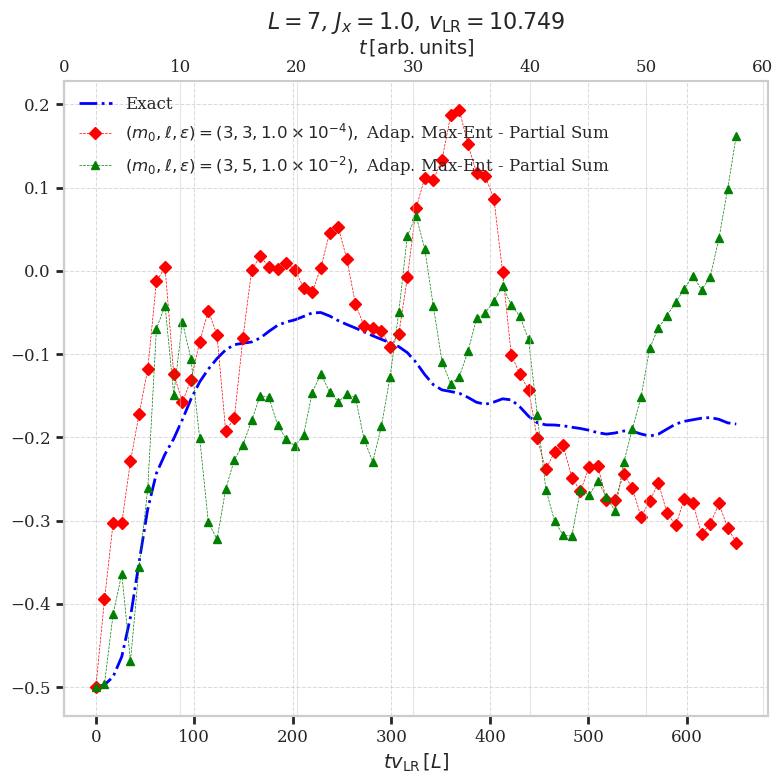

In [36]:
# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(8, 8))

n=1
ax.plot(timespan * vLR, evs_obs_ex, label='Exact', color="blue", linestyle='dashdot', linewidth=2)
ax.plot(timespan[::n] * vLR, simulations[1]["ev_obs_maxent_act_partialSum_ell"][::n], 
        label=r'$(m_0, \ell, \epsilon) = (' + sim1_parms_str +r'), $ Adap. Max-Ent - Partial Sum', color='red', linestyle='--', marker='D', linewidth=0.5)
ax.plot(timespan[::n] * vLR, simulations[2]["ev_obs_maxent_act_partialSum_ell"][::n], 
        label=r'$(m_0, \ell, \epsilon) = ('+ sim2_parms_str +r'), $ Adap. Max-Ent - Partial Sum', color='green', linestyle='--', marker='^', linewidth=0.5)
# Bordures uniquement à gauche et en bas (style minimaliste)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Personnalisation des ticks
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)

ax.legend(frameon=False, loc='upper left')

# Create a secondary x-axis (twinned) and set its limits
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[-1])

# Set axis labels
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Format the title using the `params` dictionary values
# Ensure proper LaTeX formatting and consistent escape sequences
plt.title(r'$L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

# Adjustment final et affichage
plt.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (74,) and (75,)

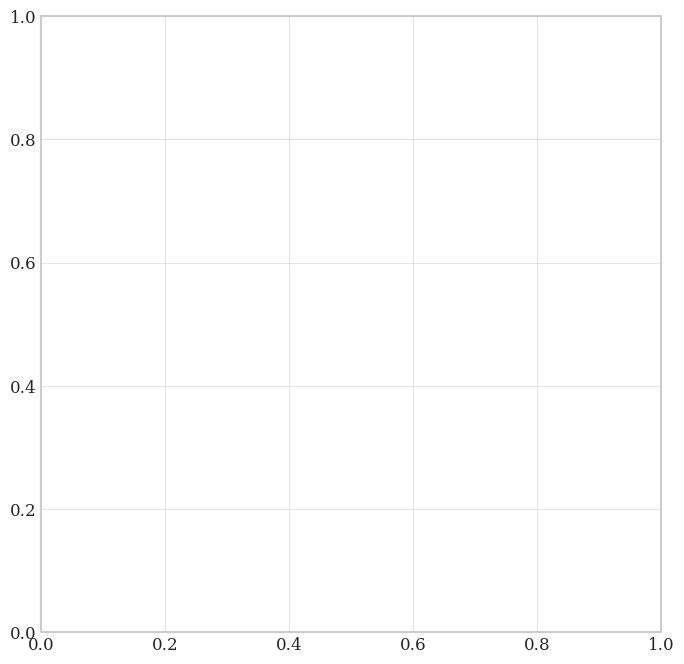

In [38]:
werror_1 = [ sum(np.real(errors)**2)**.5   for errors in simulations[1]["instantaneous_w_errors"]]
werror_2 = [ sum(np.real(errors)**2)**.5   for errors in simulations[2]["instantaneous_w_errors"]]


fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(simulations[1]["times_act_ell"][:-1][::n] * vLR, werror_1, 
        label=r'$(m_0, \ell, \epsilon) = ('+ sim1_parms_str +r'), $ Adap. Max-Ent - Partial Sum', color='red', linestyle='--', marker='D', linewidth=0.5)
ax.plot(simulations[2]["times_act_ell"][:-1][::n] * vLR, werror_2, 
        label=r'$(m_0, \ell, \epsilon) = ('+ sim2_parms_str +r'), $ Adap. Max-Ent - Partial Sum', color='green', linestyle='--', marker='^', linewidth=0.5)
ax.legend()
# Create a secondary x-axis (twinned) and set its limits
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[-1])

# Set axis labels
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Format the title using the `params` dictionary values
# Ensure proper LaTeX formatting and consistent escape sequences
plt.title(r'$L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

# Adjustment final et affichage
plt.tight_layout()